# COVID-19 Chest X-Ray Classification using Deep Learning with XAI

## HCAIM Combined Project
**Modules:** HC Deep Learning (HCDL) & Future of AI and Learning (FAI)

**Team Members:** Martin von Allesch, Dylan Byrne, Alejandro Sanchez Silva, Abdelrahman Shehata

**Date:** 

---

## 1. Setup and Imports

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn opencv-python-headless scipy split-folders

In [2]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import warnings
from pathlib import Path
from datetime import datetime

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# ML and evaluation imports
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Input, Activation
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

print("TensorFlow version:", tf.__version__)
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

# Default visualization settings
plt.style.use('default')
sns.set_palette("coolwarm")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.15.0
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration Parameters

In [14]:
# Project configuration
DATA_DIR = 'COVID-19_Radiography_Dataset'
IMG_SIZE = (224, 224) # for Densenet121 compatibility
BATCH_SIZE = 64
NUM_CLASSES = 4
CLASS_NAMES = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
EPOCHS = 30
LEARNING_RATE = 0.0005
RANDOM_SEED = 42

# Create directories for saving results
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Set random seeds
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 2. Data Loading and Exploration

In [4]:
def explore_dataset(data_dir, class_names):
    """Calculate class distribution and class weights"""
    class_counts = {}
    
    print("Dataset Exploration\n")
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name, 'images')
        if os.path.exists(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
            print(f"{class_name:20s}: {count:,} images")
        else:
            print(f"{class_name:20s}: Directory not found")
            class_counts[class_name] = 0
    
    total_images = sum(class_counts.values())
    print(f"\nTotal images: {total_images:,}")
    
    # Calculate class weights for imbalanced data
    class_weights = {}
    for idx, class_name in enumerate(class_names):
        if class_counts[class_name] > 0:
            weight = total_images / (len(class_names) * class_counts[class_name])
            class_weights[idx] = weight
    
    return class_counts, class_weights

# Explore the dataset
class_counts, class_weights = explore_dataset(DATA_DIR, CLASS_NAMES)
print(f"\nClass weights: {class_weights}")

Dataset Exploration

COVID               : 3,616 images
Normal              : 10,192 images
Viral Pneumonia     : 1,345 images
Lung_Opacity        : 6,012 images

Total images: 21,165

Class weights: {0: 1.4632881637168142, 1: 0.5191571821036107, 2: 3.934014869888476, 3: 0.8801147704590818}


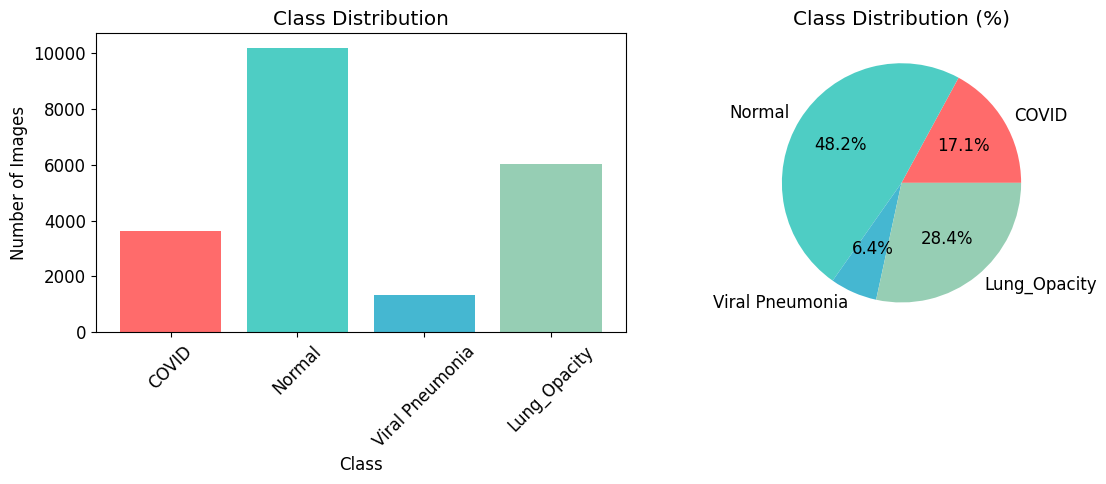

In [5]:
def visualize_class_distribution(class_counts):
    """Visualize class distribution"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    axes[0].bar(class_counts.keys(), class_counts.values(), color=colors)
    axes[0].set_title('Class Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Images')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Pie chart
    axes[1].pie(class_counts.values(), labels=class_counts.keys(), 
                autopct='%1.1f%%', colors=colors)
    axes[1].set_title('Class Distribution (%)')
    
    plt.tight_layout()
    plt.savefig('figures/class_distribution.png', dpi=150)
    plt.show()

visualize_class_distribution(class_counts)

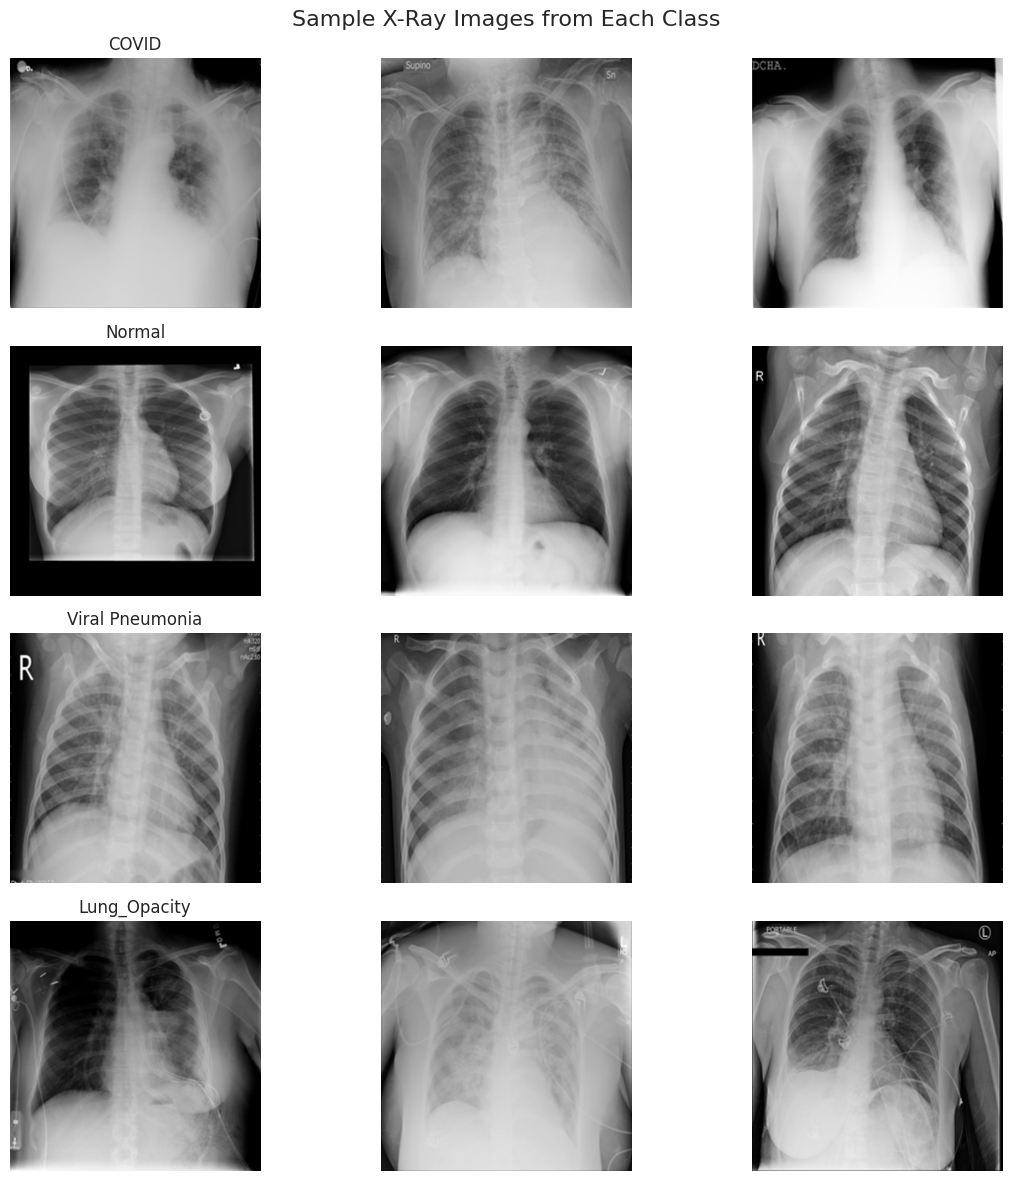

In [12]:
def visualize_sample_images(data_dir, class_names, num_samples=3):
    """Display sample images from each class"""
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(12, 12))
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name, 'images')
        if os.path.exists(class_path):
            images = os.listdir(class_path)[:num_samples]
            
            for j, img_name in enumerate(images):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(class_name)
    
    plt.suptitle('Sample X-Ray Images from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_sample_images(DATA_DIR, CLASS_NAMES)

## 3. Data Preprocessing and Augmentation

### One-time preprocessing to split images into subfolders
Note: the split-folders library performs stratified splitting by default. It processes each class folder independently, splitting that class's images according to the given ratio, then combines them. The code creates a data_split/ folder with train/, val/, test/ subdirectories, each maintaining the class folder structure and stratified proportions.

In [26]:
'''
import splitfolders
import shutil

# Create a flat structure for splitfolders
FLAT_DIR = "COVID-19_Flat"
class_folders = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

if os.path.exists(FLAT_DIR):
    shutil.rmtree(FLAT_DIR)

for class_name in class_folders:
    src = os.path.join(DATA_DIR, class_name, "images")
    dst = os.path.join(FLAT_DIR, class_name)
    shutil.copytree(src, dst)
    print(f"{class_name}: {len(os.listdir(dst))} images")

if os.path.exists("data_split"):
    shutil.rmtree("data_split")

splitfolders.ratio(
    FLAT_DIR,
    output="data_split",
    seed=RANDOM_SEED,
    ratio=(0.7, 0.15, 0.15),
    move=False
)
'''

COVID: 3616 images
Lung_Opacity: 6012 images
Normal: 10192 images
Viral Pneumonia: 1345 images


### Data Generators 
with real-time augmentation for training (rotation, shifts, flips, zoom) to reduce overfitting and improve generalization. Validation and test sets receive only pixel normalization (rescaling to 0-1) to ensure consistent evaluation. Advantage of using ImageDataGenerator is memory efficiency (images are loaded batch-by-batch) and the possibility to apply real-time augmentation and normalization.

In [19]:

# Training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# train_datagen = ImageDataGenerator(rescale=1./255)

# Validation and test data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(
    "data_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED
)

val_gen = val_datagen.flow_from_directory(
    "data_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    "data_split/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Test samples: {test_gen.samples}")

Found 14814 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.
Found 3179 images belonging to 4 classes.
Training samples: 14814
Validation samples: 3172
Test samples: 3179


## 4. Model Development

### 4.1 DenseNet121 Model with Transfer Learning (Black Box Complex)

Pretrained on ImageNet, learned features from 14M+ images, which makes it a good choice for transfer learning with limited medical data. Densenet is  widely used in radiology, e.g. CheXNet for chest X-rays. It is compatible with Grad-CAM, SHAP, and LIME for explainability.

In [20]:
def build_densenet121(num_classes, img_size, trainable_layers=20):

    # Load and configure DenseNet121 base model without classification head, using ImageNet weights
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(*img_size, 3)
    )
    base_model.trainable = False # Freeze layers initially

    # Build classification head with pooling → dense layers with regularization → output

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    '''
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),  # Reduced from 256, middle layer removed
        BatchNormalization(),
        Dropout(0.5),                   # Increased dropout
        Dense(num_classes, activation='softmax')
    ])
    '''
    # Unfreeze last n layers for fine-tuning on X-ray specific features
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    print(f"DenseNet121 built with {model.count_params():,} parameters")
    return model

# Build DenseNet121 model
densenet_model = build_densenet121(NUM_CLASSES, IMG_SIZE)

DenseNet121 built with 7,334,852 parameters


### 4.2 CNN Model (Black Box Simple)
For comparison, we implement a custom CNN. Its simpler structure makes it easier to understand learned features and shows value added by transfer learning vs training from scratch.

In [37]:
def build_cnn(num_classes, img_size):
    
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(*img_size, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    print(f"Simple CNN built with {model.count_params():,} parameters")
    return model

simple_cnn_model = build_cnn(NUM_CLASSES, IMG_SIZE)

Simple CNN built with 421,828 parameters


## 5. Model Training

### Configuration 
of optimizer, loss function, and evaluation metrics (including precision/recall/AUC for imbalanced data). Callbacks: early stopping, checkpointing for saving the best model, and learning rate scheduling for adaptive optimization.

In [21]:
def compile_model(model, learning_rate=0.001):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model

def get_callbacks(model_name):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'models/best_{model_name}_{timestamp}.keras', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        CSVLogger(f'results/{model_name}_{timestamp}_training.csv')
    ]
    return callbacks

### 5.1 Train DenseNet121

In [22]:
# Compile DenseNet121
densenet_model = compile_model(densenet_model, LEARNING_RATE)

# Train DenseNet121
print("Training DenseNet121...")
densenet_history = densenet_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=get_callbacks('densenet121'),
    class_weight=class_weights,
    verbose=1
)
print("DenseNet121 training completed!")

Training DenseNet121...
Epoch 1/30
232/232 [==============================] - 190s 795ms/step - loss: 1.6239 - accuracy: 0.6538 - precision: 0.6915 - recall: 0.6090 - auc: 0.8564 - val_loss: 0.7700 - val_accuracy: 0.7327 - val_precision: 0.7553 - val_recall: 0.6967 - val_auc: 0.9090 - lr: 5.0000e-04
Epoch 2/30
232/232 [==============================] - 182s 785ms/step - loss: 0.9659 - accuracy: 0.7498 - precision: 0.7700 - recall: 0.7247 - auc: 0.9088 - val_loss: 0.7425 - val_accuracy: 0.7620 - val_precision: 0.7715 - val_recall: 0.7481 - val_auc: 0.9239 - lr: 5.0000e-04
Epoch 3/30
232/232 [==============================] - 181s 781ms/step - loss: 0.8302 - accuracy: 0.7627 - precision: 0.7771 - recall: 0.7429 - auc: 0.9229 - val_loss: 0.6847 - val_accuracy: 0.7708 - val_precision: 0.7797 - val_recall: 0.7598 - val_auc: 0.9344 - lr: 5.0000e-04
Epoch 4/30
232/232 [==============================] - 184s 792ms/step - loss: 0.7630 - accuracy: 0.7757 - precision: 0.7887 - recall: 0.7610 - au

### 5.2 Train CNN

In [38]:
# Compile Simple CNN
simple_cnn_model = compile_model(simple_cnn_model)

# Train Simple CNN
print("Training CNN...")
cnn_history = simple_cnn_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=get_callbacks('simple_cnn'),
    class_weight=class_weights,
    verbose=1
)
print("CNN training completed!")

Training CNN...
Epoch 1/30


2025-12-08 16:46:46.124907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


232/232 [==============================] - 185s 790ms/step - loss: 1.6323 - accuracy: 0.4804 - precision: 0.4821 - recall: 0.4779 - auc: 0.6982 - val_loss: 1.2123 - val_accuracy: 0.4817 - val_precision: 0.4845 - val_recall: 0.4817 - val_auc: 0.7673 - lr: 0.0010
Epoch 2/30
232/232 [==============================] - 181s 779ms/step - loss: 1.4965 - accuracy: 0.4816 - precision: 0.4836 - recall: 0.4802 - auc: 0.7456 - val_loss: 1.1690 - val_accuracy: 0.4817 - val_precision: 0.5010 - val_recall: 0.4792 - val_auc: 0.7988 - lr: 0.0010
Epoch 3/30
232/232 [==============================] - 182s 782ms/step - loss: 1.3591 - accuracy: 0.4847 - precision: 0.5094 - recall: 0.4764 - auc: 0.7875 - val_loss: 1.0466 - val_accuracy: 0.5208 - val_precision: 0.5812 - val_recall: 0.4672 - val_auc: 0.8244 - lr: 0.0010
Epoch 4/30
232/232 [==============================] - 180s 776ms/step - loss: 1.2645 - accuracy: 0.5035 - precision: 0.5409 - recall: 0.4800 - auc: 0.8109 - val_loss: 1.0811 - val_accuracy: 0.

### 5.3 Visualize Training History

In [23]:
def plot_training_history(history, model_name):
    """Plot training history for a model"""
    # Handle both History object and dictionary
    if hasattr(history, 'history'):
        history = history.history
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Accuracy
    axes[0, 0].plot(history['accuracy'], label='Train')
    axes[0, 0].plot(history['val_accuracy'], label='Validation')
    axes[0, 0].set_title(f'{model_name} - Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history['loss'], label='Train')
    axes[0, 1].plot(history['val_loss'], label='Validation')
    axes[0, 1].set_title(f'{model_name} - Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history['precision'], label='Train')
    axes[1, 0].plot(history['val_precision'], label='Validation')
    axes[1, 0].set_title(f'{model_name} - Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history['recall'], label='Train')
    axes[1, 1].plot(history['val_recall'], label='Validation')
    axes[1, 1].set_title(f'{model_name} - Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/{model_name}_training_history.png', dpi=150)
    plt.show()

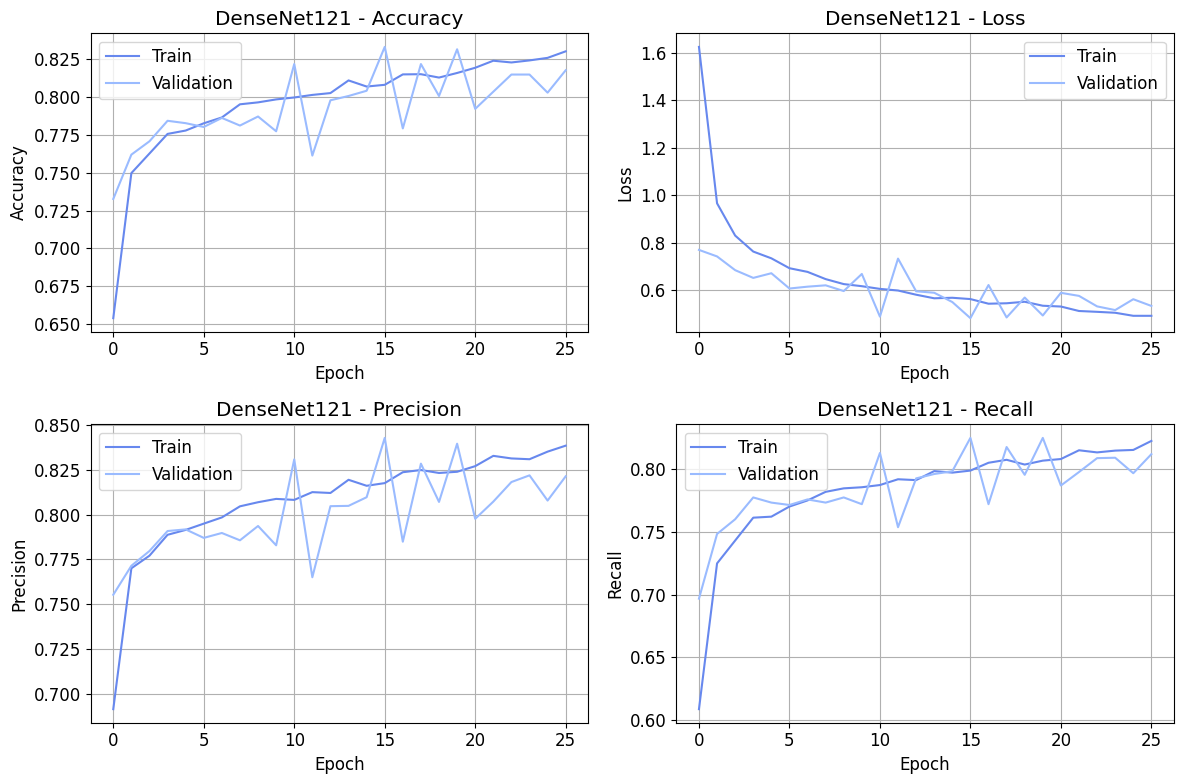

In [24]:
# Load history from CSV file
# densenet_history = pd.read_csv('results/densenet121_training.csv')

# Convert to dictionary format (like history.history)
# densenet_history = densenet_history.to_dict('list')

# Plot training histories
plot_training_history(densenet_history, 'DenseNet121')

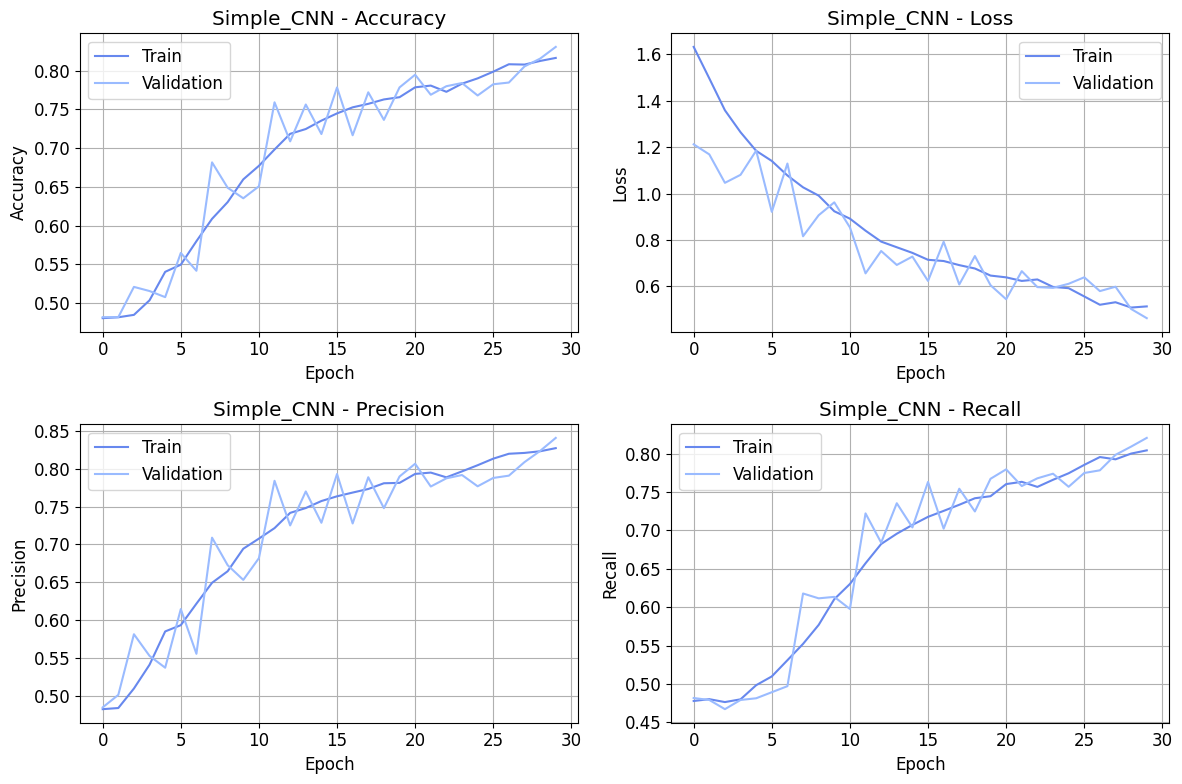

In [39]:
# Load history from CSV file
# cnn_history = pd.read_csv('results/Simple_CNN_training.csv')

# Convert to dictionary format (like history.history)
# cnn_history = cnn_history.to_dict('list')

plot_training_history(cnn_history, 'Simple_CNN')

## Glass Box Models

In [21]:
def load_data_from_folder(folder_path, image_size=(64, 64)):
    data = []
    labels = []
    
    # Get all subfolders (classes)
    # Ensure specific order if necessary, otherwise sorted() helps consistency
    classes = sorted(os.listdir(folder_path))
    
    print(f"Loading data from: {folder_path}")
    
    for label_name in classes:
        class_path = os.path.join(folder_path, label_name)
        
        # Skip files that aren't folders (e.g., .DS_Store)
        if not os.path.isdir(class_path):
            continue
            
        # Iterate over images in the class folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            
            # Read the image
            # using 0 flag reads it as Grayscale (recommended for SVM efficiency)
            img = cv2.imread(image_path, 0) 
            
            if img is not None:
                # Resize image to reduce feature count (essential for SVM)
                img = cv2.resize(img, image_size)
                
                # Flatten the image (2D -> 1D vector)
                img_flat = img.flatten()
                
                data.append(img_flat)
                labels.append(label_name)
    
    return np.array(data), np.array(labels)

### Load Dataset

In [23]:
TRAIN_PATH = './data_split/train'
VAL_PATH = './data_split/val'
TEST_PATH = './data_split/test'

# Lower resolution for pixel-based SVM
IMG_SIZE_SVM = (64, 64)

print("Loading training data for SVM...")
X_train_images, y_train = load_data_from_folder(TRAIN_PATH, IMG_SIZE_SVM)

print("\nLoading test data for SVM...")
X_test_images, y_test = load_data_from_folder(TEST_PATH, IMG_SIZE_SVM)

# Flatten
X_train = X_train_images.reshape(X_train_images.shape[0], -1)
X_test = X_test_images.reshape(X_test_images.shape[0], -1)

print(f"Features: {X_train.shape[1]}")

Loading training data for SVM...
Loading data from: ./data_split/train

Loading test data for SVM...
Loading data from: ./data_split/test
Features: 4096


### Train SVM

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.utils.class_weight import compute_class_weight

# Corrected SVM Training

# Recompute class weights from integer labels
class_weights_array = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

# Recompute class weights, as now y_train contains integer indices 
new_class_weights = dict(zip(np.unique(y_train), class_weights_array))

print("Class weights:")
print(new_class_weights)
# Expercted output: {0: 1.46, 1: 0.88, 2: 0.52, 3: 3.93}


# Create pipeline with StandardScaler to normalizes each feature to mean=0, std=1
# Without this, SVM cannot find meaningful decision boundaries

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalizes pixel values
    ('svm', svm.SVC(
        C=1.0,                           # Regularization parameter
        kernel='rbf',                    # RBF kernel for non-linear boundaries
        gamma='scale',                   # Auto-computes: 1/(n_features * X.var())
        class_weight=new_class_weights,  # Handle class imbalance
        random_state=42,
        verbose=True
    ))
])

print("\nTraining SVM model...")
print(f"  - Features: {X_train.shape[1]}")
print(f"  - Training samples: {X_train.shape[0]}")
print(f"  - Using StandardScaler + gamma='scale'")

svm_pipeline.fit(X_train, y_train)
print("\nTraining complete.")


Class weights:
{'COVID': 1.4632556301856974, 'Lung_Opacity': 0.8801093155893536, 'Normal': 0.5191337258200168, 'Viral Pneumonia': 3.9357066950053134}

Training SVM model...
  - Features: 4096
  - Training samples: 14814
  - Using StandardScaler + gamma='scale'
[LibSVM]....*.*
optimization finished, #iter = 5504
obj = -2059.706867, rho = -0.393790
nSV = 3210, nBSV = 1799
....*.*
optimization finished, #iter = 5830
obj = -1810.708725, rho = -0.331471
nSV = 3855, nBSV = 2519
*.*
optimization finished, #iter = 1010
obj = -246.234690, rho = -1.357446
nSV = 405, nBSV = 117
.....*.*
optimization finished, #iter = 6568
obj = -2147.100804, rho = 0.296076
nSV = 4537, nBSV = 2886
*.*
optimization finished, #iter = 1140
obj = -243.908617, rho = -1.082279
nSV = 537, nBSV = 228
.*
optimization finished, #iter = 1619
obj = -411.700412, rho = -1.493800
nSV = 993, nBSV = 670
Total nSV = 8599

Training complete.


### Visualize SVM Results


Test Accuracy: 84.49%

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.75      0.83      0.79       543
   Lung_Opacity       0.82      0.80      0.81       903
         Normal       0.90      0.86      0.88      1530
Viral Pneumonia       0.83      0.96      0.89       203

       accuracy                           0.84      3179
      macro avg       0.83      0.86      0.84      3179
   weighted avg       0.85      0.84      0.85      3179



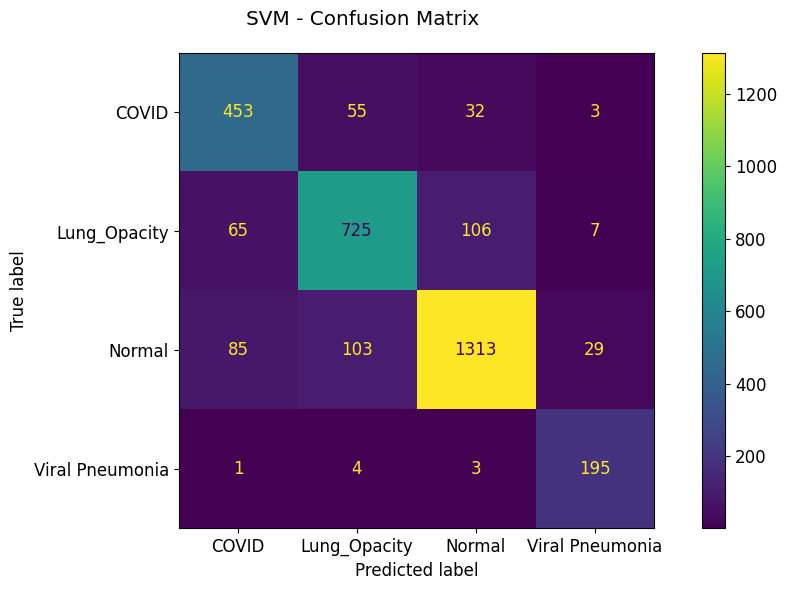

In [33]:
from sklearn import metrics
# Evaluation

# Predictions on test set
svm_pred = svm_pipeline.predict(X_test)

# Accuracy
svm_acc = metrics.accuracy_score(y_test, svm_pred)
print(f"\nTest Accuracy: {svm_acc_corrected * 100:.2f}%")

# Classification Report
print(f"\nClassification Report:")
print(metrics.classification_report(y_test, svm_pred))

# Confusion Matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
disp.figure_.suptitle("SVM - Confusion Matrix")
plt.tight_layout()
plt.savefig('figures/SVM_ConfusionMatrix.png', dpi=150)
plt.show()

### Train Decision Trees

In [36]:
from sklearn.tree import DecisionTreeClassifier
# Train Decision Tree

dt_model = DecisionTreeClassifier(
    max_depth=15,              # Prevents overfitting
    min_samples_split=10,      # Minimum samples to split
    min_samples_leaf=5,        # Minimum samples in leaf
    class_weight=new_class_weights,
    random_state=42
)

dt_model.fit(X_train, y_train)

print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")


Tree depth: 15
Number of leaves: 779


### Visualize Decision Trees Results


Test Accuracy: 69.80%

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.60      0.63      0.61       543
   Lung_Opacity       0.62      0.66      0.64       903
         Normal       0.81      0.72      0.76      1530
Viral Pneumonia       0.62      0.82      0.71       203

       accuracy                           0.70      3179
      macro avg       0.66      0.71      0.68      3179
   weighted avg       0.71      0.70      0.70      3179



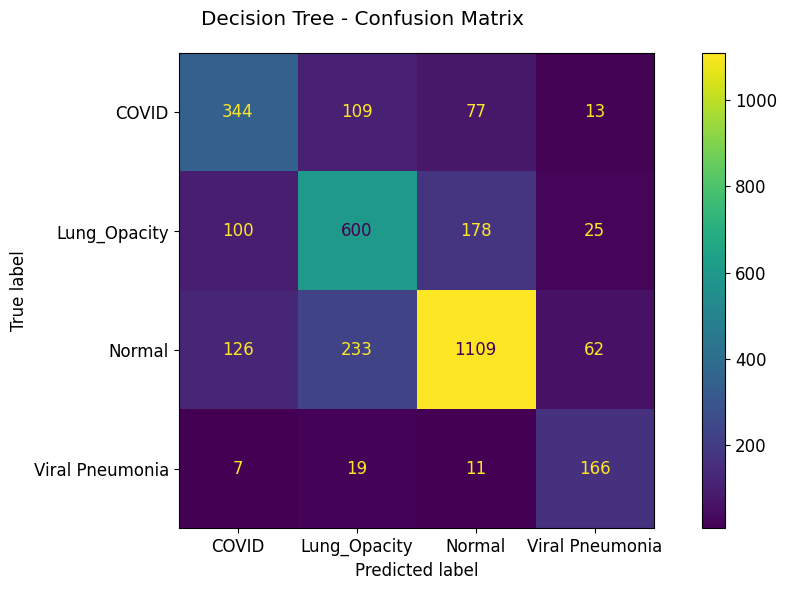

In [38]:
# Evaluate
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

print(f"\nTest Accuracy: {dt_accuracy * 100:.2f}%")

target_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
print(f"\nClassification Report:")
print(classification_report(y_test, dt_pred, target_names=target_names))

# Confusion Matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, dt_pred)
disp.figure_.suptitle("Decision Tree - Confusion Matrix")
plt.tight_layout()
plt.savefig('figures/DT_ConfusionMatrix.png', dpi=150)
plt.show()